In [1]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (38,45) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


# Pvalue for Zmean from sib

In [71]:
EFFECTS = []
for i in range(1000):
    tmp = ssc_sib.sample(n=101)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, Sib_sample101, Method=1)
    effect = np.array(Sib_avgZ1["EFFECT"].values)
    EFFECTS.append(effect)
EFFECTS = np.array(EFFECTS)

In [73]:
np.save("dat/bias/effects_sib.nparr", EFFECTS)

In [75]:
EFFECTS.shape

(1000, 213)

(array([  4.,  23.,  66., 168., 272., 256., 135.,  53.,  18.,   5.]),
 array([-0.03107105, -0.0233376 , -0.01560414, -0.00787069, -0.00013723,
         0.00759623,  0.01532968,  0.02306314,  0.0307966 ,  0.03853005,
         0.04626351]),
 <a list of 10 Patch objects>)

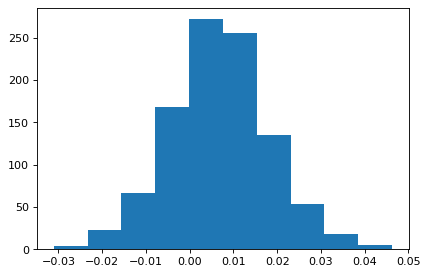

In [90]:
plt.hist(EFFECTS[:, 100])

In [91]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS[:, i], effect)
    else:
        pvalue = GetPermutationP(EFFECTS[:, i], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue

In [92]:
Meta_Zscore.to_csv('dat/bias/test.csv')

## De novo Simulations

In [95]:
denovo_simulations = pd.read_csv("dat/meta_denovo_simulations.csv", index_col = "index")
denovo_simulations.head(2)

,1,2,131076,12,13,14,15,16,18,163859,...,196513,196527,196528,196541,163782,163786,6503,131034,327657,201895
index,,,,,,,,,,,,,,,,,,,,,
0,"0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,1","1,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
1,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","1,0","0,1","0,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0"


In [129]:
def sim_denovo_row2gweight(row, n_gene=101, LGD_Weight = 0.357, DMIS_Weight = 0.231):
    dat = []
    for index, value in row.items():
        N_lgd, N_dmis = map(int, value.split(","))
        #print(index, N_lgd, N_dmis)
        if N_lgd + N_dmis == 0:
            continue
        dat.append([index, N_lgd, N_dmis, N_lgd * LGD_Weight + N_dmis * DMIS_Weight])
    df = pd.DataFrame(data=dat, columns=["Entrez", "NLGD", "NDmis", "Weight"])
    df = df.sort_values("Weight", ascending=False)
    top = df.head(n_gene)
    return dict(zip([int(x) for x in top["Entrez"].values], top["Weight"].values))

In [132]:
EFFECTS = []
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    effect = np.array(sim_avgZ1["EFFECT"].values)
    EFFECTS.append(effect)
EFFECTS = np.array(EFFECTS)

In [133]:
np.save("dat/bias/effects_sim.nparr", EFFECTS)

In [134]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS[:, i], effect)
    else:
        pvalue = GetPermutationP(EFFECTS[:, i], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
Meta_Zscore.to_csv('dat/bias/test.csv')

(array([ 36., 139., 232., 246., 180.,  86.,  51.,  18.,   9.,   3.]),
 array([0.05159681, 0.0607005 , 0.06980418, 0.07890787, 0.08801156,
        0.09711525, 0.10621894, 0.11532263, 0.12442632, 0.13353001,
        0.1426337 ]),
 <a list of 10 Patch objects>)

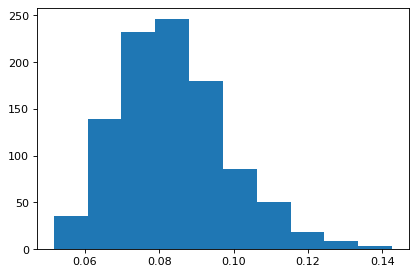

In [139]:
plt.hist(EFFECTS[:, 50])

(array([ 4.,  4., 21., 46., 51., 50., 22.,  8.,  5.,  2.]),
 array([-0.38713945, -0.30449129, -0.22184313, -0.13919496, -0.0565468 ,
         0.02610136,  0.10874952,  0.19139768,  0.27404584,  0.356694  ,
         0.43934216]),
 <a list of 10 Patch objects>)

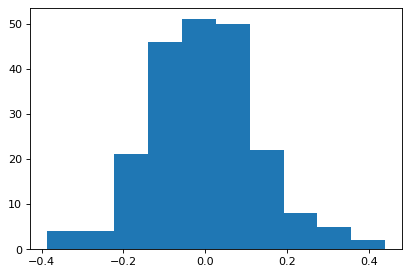

In [140]:
plt.hist(EFFECTS[1, :])

In [143]:
## Dist as same STR
EFFECTS2 = {}
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    for STR, row in sim_avgZ1.iterrows():
        #print(STR, EFFECT)
        if STR in EFFECTS2:
            EFFECTS2[STR].append(row["EFFECT"])
        else:
            EFFECTS2[STR] = [row["EFFECT"]]

In [145]:
#EFFECTS2[]
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS2[_str], effect)
    else:
        pvalue = GetPermutationP(EFFECTS2[_str], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
Meta_Zscore.to_csv('dat/bias/test2.csv')

In [193]:
dat = []
for k, v in EFFECTS2.items():
    dat.append([k, np.mean(v), np.var(v)])
null = pd.DataFrame(data=dat, columns=["STR", "MEAN", "VAR"])
null = null.sort_values("MEAN", ascending=False)
null.index = null["STR"].values

In [194]:
null

,STR,MEAN,VAR
Anterior_pretectal_nucleus,Anterior_pretectal_nucleus,0.250317,0.009316
Inferior_colliculus_central_nucleus,Inferior_colliculus_central_nucleus,0.196168,0.008804
Inferior_colliculus_external_nucleus,Inferior_colliculus_external_nucleus,0.195882,0.009545
Nucleus_of_the_optic_tract,Nucleus_of_the_optic_tract,0.184289,0.008402
Lateral_posterior_nucleus_of_the_thalamus,Lateral_posterior_nucleus_of_the_thalamus,0.159468,0.008886
...,...,...,...
Retrochiasmatic_area,Retrochiasmatic_area,-0.147751,0.006912
Substantia_nigra_compact_part,Substantia_nigra_compact_part,-0.162306,0.007995
Nucleus_raphe_magnus,Nucleus_raphe_magnus,-0.168415,0.008699
Tuberal_nucleus,Tuberal_nucleus,-0.168593,0.007232


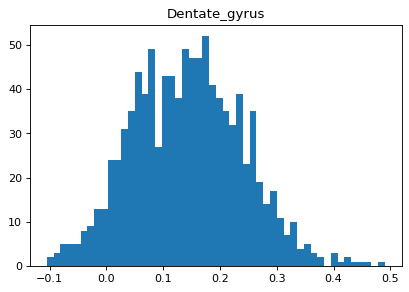

In [238]:
plt.hist(EFFECTS2["Dentate_gyrus"], bins=50)
plt.title("Dentate_gyrus")
plt.show()

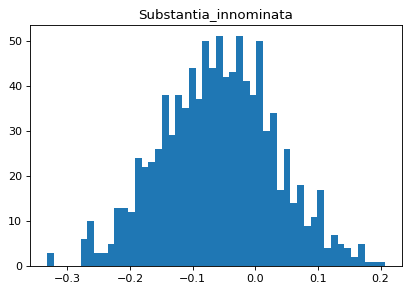

In [239]:
plt.hist(EFFECTS2["Substantia_innominata"], bins=50)
plt.title("Substantia_innominata")
plt.show()

In [195]:
STR2REG = STR2Region()
for i, row in null.iterrows():
    null.loc[i, "REG"] = STR2REG[row["STR"]]

In [196]:
null.head(5)

,STR,MEAN,VAR,REG
Anterior_pretectal_nucleus,Anterior_pretectal_nucleus,0.250317,0.009316,Midbrain
Inferior_colliculus_central_nucleus,Inferior_colliculus_central_nucleus,0.196168,0.008804,Midbrain
Inferior_colliculus_external_nucleus,Inferior_colliculus_external_nucleus,0.195882,0.009545,Midbrain
Nucleus_of_the_optic_tract,Nucleus_of_the_optic_tract,0.184289,0.008402,Midbrain
Lateral_posterior_nucleus_of_the_thalamus,Lateral_posterior_nucleus_of_the_thalamus,0.159468,0.008886,Thalamus


In [197]:
REGs = list(set(null["REG"].values))

In [227]:
dat = []
for reg in REGs:
    dat.append([reg, np.mean(null[null["REG"]==reg]["MEAN"].values)])
torank = pd.DataFrame(data=dat, columns=["REG", "MEAN"])
torank = torank.sort_values("MEAN")
torank.head(2)
REGs = torank["REG"].values

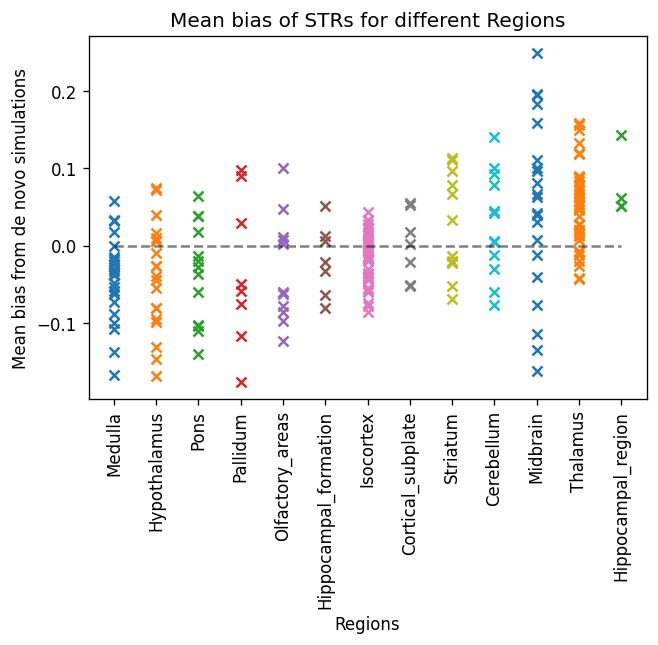

In [228]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["MEAN"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=0, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Mean bias of STRs for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Mean bias from de novo simulations")
plt.show()

In [240]:
mean_var = null["VAR"].mean()

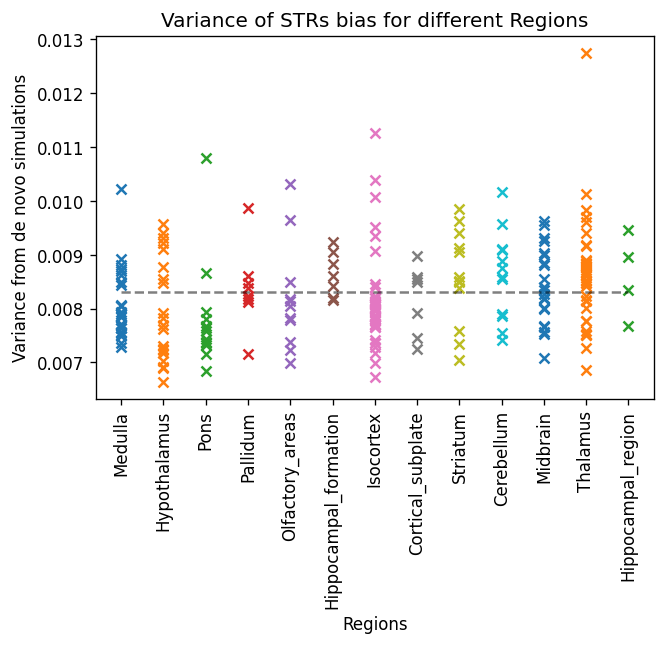

In [242]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["VAR"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=mean_var, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Variance of STRs bias for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Variance from de novo simulations")
plt.show()

In [201]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS2[_str], effect)
    else:
        pvalue = GetPermutationP(EFFECTS2[_str], effect, gt = False)
    new_effect = effect - null.loc[_str, "MEAN"]
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
    Meta_Zscore.loc[_str, "EFFECT2"] = new_effect
Meta_Zscore.to_csv('dat/bias/test3.csv')

In [ ]:
## Qunatils checking

In [205]:
ExpZscoreMat.head(2)

,Anterior_amygdalar_area,Anterior_cingulate_area_dorsal_part,Anterior_cingulate_area_ventral_part,Nucleus_accumbens,Anterodorsal_nucleus,Anterior_hypothalamic_nucleus,Agranular_insular_area_dorsal_part,Agranular_insular_area_posterior_part,Agranular_insular_area_ventral_part,Nucleus_ambiguus,...,Primary_visual_area,Posterolateral_visual_area,posteromedial_visual_area,Ventral_medial_nucleus_of_the_thalamus,Ventromedial_hypothalamic_nucleus,Ventral_posterolateral_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,Ventral_tegmental_area,Hypoglossal_nucleus
ROW,,,,,,,,,,,,,,,,,,,,,
1,0.160640,-0.539153,-0.504043,-0.761513,-0.693056,1.644456,-0.925718,NaN,-0.445816,-0.491676,...,-0.826146,1.096054,-1.042356,-0.149321,1.309056,-0.090982,0.224140,-0.079631,1.733742,0.713978
2,-0.476558,-0.559858,-0.517535,-0.524070,0.155116,-0.414605,-0.132720,-0.366087,-0.228981,-0.431621,...,-0.477847,-0.507564,-0.227819,-0.304092,-0.342912,-0.505963,-0.469515,-0.360610,-0.054245,1.149715


In [ ]:
ExpZscoreMat

In [219]:
def get_percentile(STR, MAT = ExpZscoreMat, P=[10, 50, 90]):
    values = MAT[STR].values
    values = [x for x in values if x==x]
    res = []
    for p in P:
        res.append(np.percentile(values, q=p))
    return res

In [220]:
print(get_percentile("Anterior_amygdalar_area"))
print(get_percentile("Anterior_cingulate_area_dorsal_part"))
print(get_percentile("Anterior_cingulate_area_ventral_part"))
print(get_percentile("Ventral_tegmental_area"))

[-1.0036701566616328, -0.188189282385728, 1.2515600583166464]
[-1.0036701565866828, -0.18818928298236598, 1.2515600524549726]
[-1.0036702236757309, -0.18818928405823449, 1.251565298976829]
[-1.0036701846273999, -0.18818834763392, 1.2515622453055562]


In [246]:
denovo_simulations.head(2)

,1,2,131076,12,13,14,15,16,18,163859,...,196513,196527,196528,196541,163782,163786,6503,131034,327657,201895
index,,,,,,,,,,,,,,,,,,,,,
0,"0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,1","1,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
1,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","1,0","0,1","0,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0"


### P value for expression level

In [265]:
## Construct expression match matrix
#denovo_simulations.head(2)
dat = []
_dir = "dat/Match_Volume_W/"
_index = np.empty(0)
no_g = []
for g in denovo_simulations.columns.values:
    try:
        tmp = loadgenelist(_dir + str(g) + ".txt.gz")
    except:
        no_g.append(g)
    dat.append(tmp)
    _index = np.append(_index, g)
Sim_Denovo_Matching = pd.DataFrame(data=dat, index=_index)

In [266]:
Sim_Denovo_Matching.head(2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,23581,162605,152687,9245,131540,915,130162,285172,219432,254013,...,9702,389336,6557,167555,126282,368,5330,8406,79589,130589
2,54971,2297,1842,117145,51360,1293,54881,56927,84725,3290,...,2651,4739,5317,146852,3655,83894,6780,92002,54457,3589


In [253]:
print(no_g)

['100499483', '100996939', '100505591', '100505993', '100506049', '100506564', '100506581', '100506658', '100506736', '100310846', '100288797', '101928601']


In [259]:
Sim_Denovo_Matching.index

Index(['1', '2', '131076', '12', '13', '14', '15', '16', '18', '163859',
       ...
       '196513', '196527', '196528', '196541', '163782', '163786', '6503',
       '131034', '327657', '201895'],
      dtype='object', length=13752)

In [268]:
Sim_Denovo_Matching.loc['54971', :]

0       64801
1       27131
2       85441
3       92002
4        5449
        ...  
995      5978
996     79134
997     25855
998    253714
999     84725
Name: 54971, Length: 1000, dtype: int64

In [ ]:
## Dist as same STR
EFFECTS2 = {}
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    
    #sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    #for STR, row in sim_avgZ1.iterrows():
        #print(STR, EFFECT)
    #    if STR in EFFECTS2:
    #        EFFECTS2[STR].append(row["EFFECT"])
    #    else:
    #        EFFECTS2[STR] = [row["EFFECT"]]

In [269]:
DIR = "/Users/jiayao/Work/ASD_Circuits/src/dat/bias/DNV_SM_ExpLevel/"
EXP_LEVEL_EFFECT = {}
for i in range(1000):
    tmp_df = pd.read_csv("{}/dnv_sm.{}.csv".format(DIR, i), index_col="STR")
    for STR, row in tmp_df.iterrows():
        #print(STR, EFFECT)
        if STR in EXP_LEVEL_EFFECT:
            EXP_LEVEL_EFFECT[STR].append(row["EFFECT"])
        else:
            EXP_LEVEL_EFFECT[STR] = [row["EFFECT"]]

In [271]:
dat = []
for k, v in EXP_LEVEL_EFFECT.items():
    dat.append([k, np.mean(v), np.var(v)])
null = pd.DataFrame(data=dat, columns=["STR", "MEAN", "VAR"])
null = null.sort_values("MEAN", ascending=False)
null.index = null["STR"].values

In [272]:
STR2REG = STR2Region()
for i, row in null.iterrows():
    null.loc[i, "REG"] = STR2REG[row["STR"]]
REGs = list(set(null["REG"].values))  
dat = []
for reg in REGs:
    dat.append([reg, np.mean(null[null["REG"]==reg]["MEAN"].values)])
torank = pd.DataFrame(data=dat, columns=["REG", "MEAN"])
torank = torank.sort_values("MEAN")
torank.head(2)
REGs = torank["REG"].values

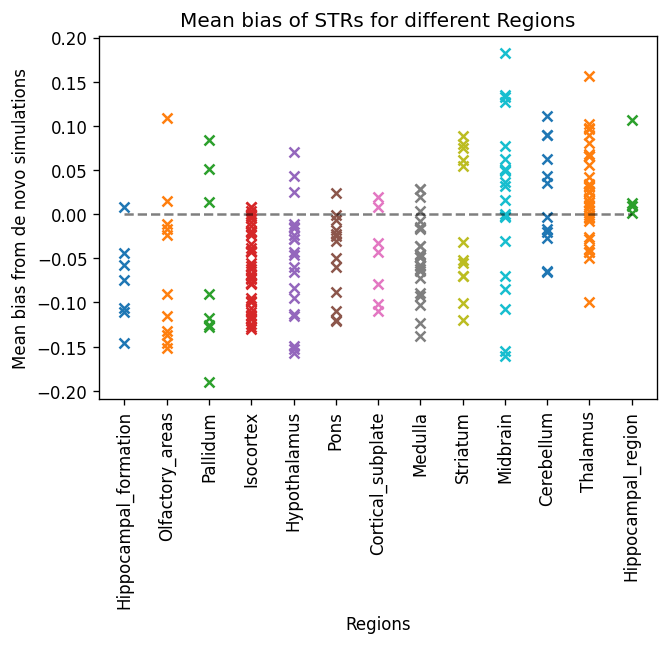

In [273]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["MEAN"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=0, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Mean bias of STRs for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Mean bias from de novo simulations")
plt.show()

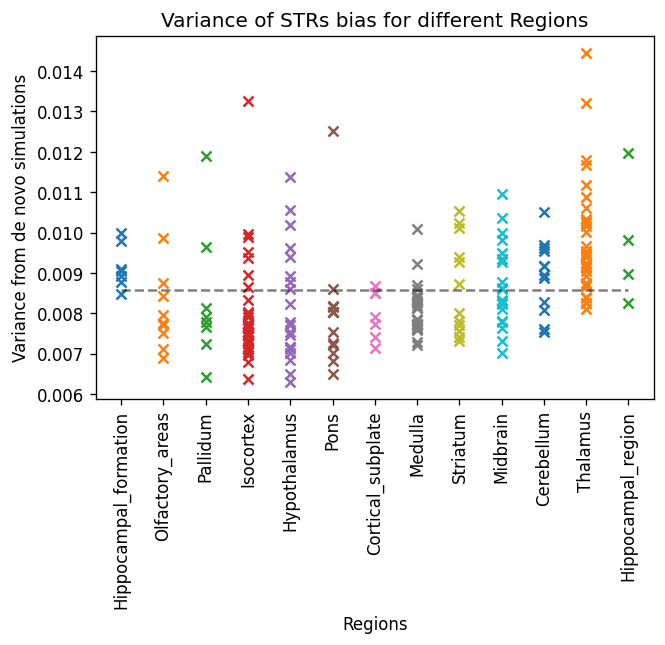

In [274]:
mean_var = null["VAR"].mean()
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["VAR"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=mean_var, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Variance of STRs bias for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Variance from de novo simulations")
plt.show()

In [276]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.explevel.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EXP_LEVEL_EFFECT[_str], effect)
    else:
        pvalue = GetPermutationP(EXP_LEVEL_EFFECT[_str], effect, gt = False)
    new_effect = effect - null.loc[_str, "MEAN"]
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
    Meta_Zscore.loc[_str, "EFFECT2"] = new_effect
Meta_Zscore.to_csv('dat/bias/test4.csv')

# Compare 3 different method for sepcificity bias

In [2]:
Aggregate = pd.read_csv("../dat/genes/asd/DenovoWEST_TADA.txt", delimiter="\t")
Aggregate['pDenovoWEST'] = pd.to_numeric(Aggregate["pDenovoWEST"], errors='coerce')
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, out = "dat/bias2/meta.gene.weights.csv")
Agg_match_df = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.new.csv", index_col="GENE")
print(len(Agg_gene2MutN))

101


In [39]:
Agg_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=1,
                                              csv_fil = "dat/bias3/Agg.AvgZ1.Mutcount.bias.csv")

41


In [12]:
Agg_avgZ2 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=2, Match_DF=Agg_match_df, 
                                              csv_fil = "dat/bias3/Agg.AvgZ2.Mutcount.bias.csv")

39


In [15]:
Agg_avgZ3 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=3, Match_DF=Agg_match_df, 
                                              csv_fil = "dat/bias3/Agg.AvgZ3.Mutcount.bias.csv")

38


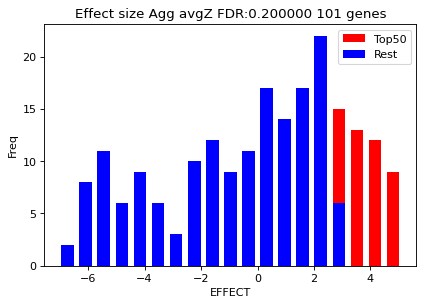

In [40]:
PlotEffectDist(Agg_avgZ3, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

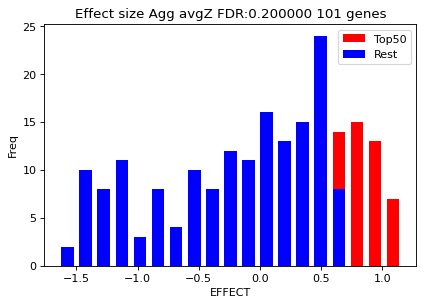

In [20]:
PlotEffectDist(Agg_avgZ2, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

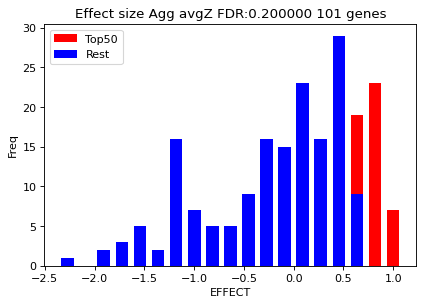

In [21]:
PlotEffectDist(Agg_avgZ1, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [17]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ3.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Rhomboid_nucleus; Mediodorsal_nucleus_of_thalamus
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Anterior_cingulate_area_dorsal_part; Anteromedial_visual_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Agranular_insular_area_ventral_part; Secondary_motor_area; Gustatory_areas; Visceral_area; Lateral_visual_area; Dorsal_auditory_area; Posterior_parietal_association_areas; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Posterolateral_visual_area
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Olfactory_areas 	 4 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory

In [18]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ2.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 6 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus
Isocortex 	 21 	 Orbital_area_lateral_part; Prelimbic_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Retrosplenial_area_lateral_agranular_part; Primary_motor_area; Secondary_motor_area; Gustatory_areas; Visceral_area; Agranular_insular_area_ventral_part; Dorsal_auditory_area; Orbital_area_medial_part; Lateral_visual_area; Primary_somatosensory_area_trunk; Posterior_parietal_association_areas; Agranular_insular_area_posterior_part; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum; Presubiculum
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_pedun

In [19]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ1.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 8 	 Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Parafascicular_nucleus; Nucleus_of_reuniens; Intermediodorsal_nucleus_of_the_thalamus; Paraventricular_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Submedial_nucleus_of_the_thalamus
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Dorsal_auditory_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_visual_area; Primary_somatosensory_area_lower_limb; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_posterior_part; Retrosplenial_area_lateral_agranular_part; Visceral_area; Secondary_motor_area; Orbital_area_medial_part; Primary_motor_area; Lateral_visual_area; Posterolateral_visual_area; Agranular_insular_area_ventral_part; Gustatory_areas; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Su

# For Method 3, Does it able to normlize gene set size?

In [23]:
ssc_all = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/Supplementary_Table_7.xlsx")
ssc_sib = ssc_all[(ssc_all["dnv_LGDs_sib"]!=0) | (ssc_all["dnv_missense_sib"]!=0)]

In [24]:
ssc_sib.shape

(1215, 29)

In [25]:
tmp = ssc_sib.sample(n=101)

In [26]:
tmp.shape

(101, 29)

In [32]:
def sibling_gene_weight(df):
    gene2MutN = {}
    for i, row in df.iterrows():
        try:
            g = GeneSymbol2Entrez[row["gene"]]
            gene2MutN[g] = row["dnv_LGDs_sib"]*0.375 + (row["dnv_missense_sib"]) * 0.145
        except:
            continue
    return gene2MutN

In [41]:
tmp = ssc_sib.sample(n=101)
Sib_sample101 = sibling_gene_weight(tmp)
print(len(Sib_sample101))

94


In [42]:
Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1,
                                              csv_fil = "dat/bias3/Sib.AvgZ1.Mutcount.bias.csv")

35


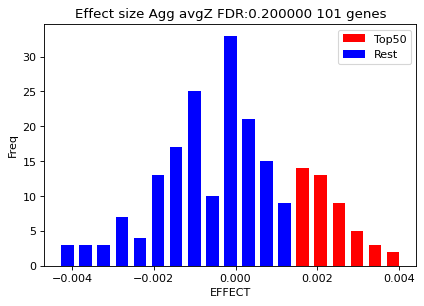

In [43]:
PlotEffectDist(Sib_avgZ1, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [48]:
for i in range(10):
    tmp = ssc_sib.sample(n=101)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.0019389413868474712 5.378630752479766e-07
0.00212888363670234 1.7775576724506274e-06
0.0016110278965608001 1.3050112890064857e-06
0.0019358141239947896 5.760567288389296e-07
0.0022852619988945146 7.708278715898236e-07
0.0031768258531090377 2.2397084615744967e-06
0.0023976437120662992 7.834306513733399e-07
0.002349322249294572 1.029242751347744e-06
0.0020237881053463396 2.221745386863179e-06
0.0019175731271255324 5.128107621677241e-07


In [49]:
for i in range(10):
    tmp = ssc_sib.sample(n=51)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.0056178484525570005 2.7923883679755892e-06
0.0063490141009708775 6.71122461813859e-06
0.006272680032825859 7.2703626914502964e-06
0.004640283704860911 9.524726181487976e-06
0.007033120044551493 3.6697212756592134e-05
0.0053330014479219855 4.446320349635775e-06
0.004881409060390986 3.2799961958770596e-06
0.008129327437749478 2.2443012497996824e-05
0.005829531961867925 7.041011879232908e-06
0.006899409318098098 1.1198934525975897e-05


In [50]:
for i in range(10):
    tmp = ssc_sib.sample(n=200)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.001100446505943761 2.988754348972949e-07
0.0011642074229136932 7.341448714940769e-07
0.0010108115411336094 4.5438772774939387e-07
0.0007369056751881707 2.392685044830714e-07
0.0007036137265139063 5.696060924448429e-08
0.00099602873182754 3.12551865580685e-07
0.0008208283876010277 2.821142591447742e-07
0.0006866171908992538 1.9505664913639837e-07
0.0010822239264682272 1.9859062228758234e-07
0.0008399816450629278 1.6045526842913665e-07


In [ ]:
print("hj")

In [56]:
Sib_match = Agg_match_df = pd.read_csv("dat/matching/asd_sib_exp_matches_1000.csv", index_col="GENE")

In [58]:
tmp = ssc_sib.sample(n=51)
Sib_sample51 = sibling_gene_weight(tmp)
Sib_avgZ3_51 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample51, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_51.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

230.46532803896204 4366.858251996743


In [59]:
tmp = ssc_sib.sample(n=101)
Sib_sample101 = sibling_gene_weight(tmp)
Sib_avgZ3_101 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_101.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

47.95358833527919 498.3731183045462


In [60]:
tmp = ssc_sib.sample(n=201)
Sib_sample201 = sibling_gene_weight(tmp)
Sib_avgZ3_201 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample201, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_201.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

24.469691297297096 160.61366363201324
